In [1]:
import time
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.decomposition.candecomp_parafac import initialize_factors, unfolding_dot_khatri_rao, KruskalTensor

In [2]:
# for sample video
from cv2 import VideoWriter, VideoWriter_fourcc

def make_video(tensor, filename):
    start = time.time()
    height = tensor.shape[1]
    width = tensor.shape[2]
    FPS = 24

    fourcc = VideoWriter_fourcc(*'MP42')
    video = VideoWriter(filename, fourcc, float(FPS), (width, height))

    for frame in tensor:
        video.write(np.uint8(frame))
    video.release()
    print('created', filename, time.time()-start)

In [3]:
import math
class Welford(object):
    def __init__(self,lst=None):
        self.k = 0
        self.M = 0
        self.S = 0
        
        self.__call__(lst)
    
    def update(self,x):
        if x is None:
            return
        self.k += 1
        newM = self.M + (x - self.M)*1./self.k
        newS = self.S + (x - self.M)*(x - newM)
        self.M, self.S = newM, newS

    def consume(self,lst):
        lst = iter(lst)
        for x in lst:
            self.update(x)
    
    def __call__(self,x):
        if hasattr(x,"__iter__"):
            self.consume(x)
        else:
            self.update(x)
            
    @property
    def mean(self):
        return self.M
    @property
    def meanfull(self):
        return self.mean, self.std/math.sqrt(self.k)
    @property
    def std(self):
        if self.k==1:
            return 0
        return math.sqrt(self.S/(self.k-1))
    def __repr__(self):
        return "<Welford: {} +- {}>".format(self.mean, self.std)

In [4]:
def construct_tensor(factors):
    weights = tl.ones(factors[0].shape[1])
    est_tensor = tl.kruskal_to_tensor((weights, factors))
    return est_tensor
    
def print_tensor(X, n_digit=1):
    print(np.round(X, n_digit))
    
def compare_tensors(A, B):
    error_norm = tl.norm(A - B)
    print('||A-B||:', error_norm)
    return error_norm
    
def create_tensor_stream(X, start_to_stream, batch_sizes):
    total_batch_size = np.sum(batch_sizes)
    if X.shape[0] != start_to_stream + total_batch_size:
        raise ValueError('Total batch size should be the size of streaming part of the tensor.')
    
    X_stream = [X[:start_to_stream]]
    batch_start = start_to_stream
    for batch_size in batch_sizes:
        batch_end = batch_start + batch_size
        X_stream.append(X[batch_start:batch_end])
        batch_start = batch_end
    return np.asarray(X_stream)
    
def get_KhatriRao(factors):
    n_dim = len(factors)
    lefts = [factors[n_dim-1]]
    rights = [factors[0]]
    if n_dim > 2:
        for mode in range(1, n_dim-1):
            lefts.append(tl.tenalg.khatri_rao((lefts[mode-1], factors[n_dim-mode-1])))
            rights.append(tl.tenalg.khatri_rao((factors[mode], rights[mode-1])))
            
    K = lefts.copy()
    K[0] = lefts[n_dim-2]
    K.append(rights[n_dim-2].copy())
    if n_dim > 2:
        for mode in range(1, n_dim-1):
            K[mode] = tl.tenalg.khatri_rao((lefts[n_dim-mode-2], rights[mode-1]))
    return K

def get_KhatriRao_except0(factors):
    n_dim = len(factors)
    lefts = np.empty((n_dim), dtype=object)
    rights = np.empty((n_dim), dtype=object)
    K = np.empty((n_dim), dtype=object)
    
    lefts[1] = factors[n_dim-1]
    rights[1] = factors[1]
    if n_dim > 3:
        for mode in range(2, n_dim-1):
            lefts[mode] = tl.tenalg.khatri_rao((factors[n_dim-mode], lefts[mode-1]))
            rights[mode] = tl.tenalg.khatri_rao((rights[mode-1], factors[mode]))
            
    K[1] = lefts[n_dim-2]
    K[n_dim-1] = rights[n_dim-2]
    if n_dim > 3: 
        for mode in range(2, n_dim-1):
            K[mode] = tl.tenalg.khatri_rao((rights[mode-1], lefts[n_dim-mode-1]))
    return K
    
def get_Hadamard(factors):
    rank = factors[0].shape[1]
    H = tl.tensor(np.ones((rank, rank)))
    for factor in factors:
        H = H * tl.dot(tl.transpose(factor), factor)
    return H

### Online CP

In [ ]:
def online_cp(factors_old, X_old, X_new, rank, P, Q, n_iter=1, mu=1, verbose=False, transformed=False):
    weights = tl.ones(rank)
    if verbose:
        X = tl.tensor(np.concatenate((X_old, X_new)))
    n_dim = tl.ndim(X_old)
    U = factors_old.copy()
    
    if not transformed:
        K = get_KhatriRao_except0(factors_old)
    H = get_Hadamard(factors_old[1:])
        
    for i in range(n_iter):
        # temporal mode for A1
        if not transformed:
            mttkrp = tl.dot(tl.unfold(X_new, 0), tl.tenalg.khatri_rao((U[1], K[1])))
        else:
            # for higher accracy, lower speed
            mttkrp_parts = []
            for r in range(rank):
                component = tl.tenalg.multi_mode_dot(X_new, [f[:, r] for f in U], skip=0)
                mttkrp_parts.append(component)
            mttkrp = np.stack(mttkrp_parts, axis=1)
        
        A1 = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))

        # non-temporal mode
        for mode in range(1, n_dim):
            
            if not transformed:
                dP = tl.dot(tl.unfold(X_new, mode), tl.tenalg.khatri_rao((A1, K[mode])))
                UTU  = tl.dot(tl.transpose(U[mode]), U[mode])
                dQ = tl.dot(tl.transpose(A1), A1) * H / UTU
                
                U[mode] = tl.transpose(tl.solve(tl.transpose(mu*Q[mode] + dQ), tl.transpose(mu*P[mode] + dP)))
                P[mode] = P[mode] + dP
                Q[mode] = Q[mode] + dQ
            else:
                U1 = U.copy()
                U1[0] = A1
                
                H_mode  = H / tl.dot(tl.transpose(U[mode]), U[mode])
                V = (mu * tl.dot(tl.transpose(U[0]), U[0]) + tl.dot(tl.transpose(A1), A1)) * H_mode
                
                mttkrp0 = unfolding_dot_khatri_rao(X_old, (None, U), mode)
                mttkrp1 = unfolding_dot_khatri_rao(X_new, (None, U1), mode)
                
                U[mode] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mu*mttkrp0 + mttkrp1)))
                H = H_mode * tl.dot(tl.transpose(U[mode]), U[mode])
                
        # temporal mode for A0
        if transformed:
            mttkrp = unfolding_dot_khatri_rao(X_old, (None, U), 0)
            U[0] = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))
            
        if verbose:
            U1 = U.copy()
            U1[0] = np.concatenate((U[0], A1))
            X_est = construct_tensor(U1)
            compare_tensors(X, X_est)

    U[0] = np.concatenate((U[0], A1))
    return (KruskalTensor((weights, U)), P, Q)

### DTD

In [194]:
def dtd(factors_old, X_old, X_new, rank, n_iter=1, mu=1, verbose=False):
    
    weights = tl.ones(rank)
    if verbose:
        X = tl.tensor(np.concatenate((X_old, X_new)))
    n_dim = tl.ndim(X_old)
    U = factors_old.copy()
    
    for i in range(n_iter):
        # temporal mode for A1
        V = tl.tensor(np.ones((rank, rank)))
        for j, factor in enumerate(U):
            if j != 0:
                V = V * tl.dot(tl.transpose(factor), factor)
        mttkrp = unfolding_dot_khatri_rao(X_new, (None, U), 0)
        A1 = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp)))

        # non-temporal mode
        for mode in range(1, n_dim):
            U1 = U.copy()
            U1[0] = A1
            V = tl.tensor(np.ones((rank, rank)))
            W = tl.tensor(np.ones((rank, rank)))
            for j, factor in enumerate(U):
                factor_old = factors_old[j]
                if j != mode:
                    W = W * tl.dot(tl.transpose(factor_old), factor)
                    if j == 0:
                        V = V * (mu*tl.dot(tl.transpose(factor), factor) + tl.dot(tl.transpose(A1), A1))
                    else:
                        V = V * tl.dot(tl.transpose(factor), factor)
            mttkrp0 = mu * tl.dot(factors_old[mode], W)
            mttkrp1 = unfolding_dot_khatri_rao(X_new, (None, U1), mode)
            U[mode] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp0 + mttkrp1)))

        # temporal mode for A0
        V = tl.tensor(np.ones((rank, rank)))
        W = tl.tensor(np.ones((rank, rank)))
        for j, factor in enumerate(U):
            factor_old = factors_old[j]
            if j != 0:
                V = V * tl.dot(tl.transpose(factor), factor)
                W = W * tl.dot(tl.transpose(factor_old), factor)
        mttkrp = tl.dot(factors_old[0], W)
        U[0] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp)))
        if verbose:
            U1 = U.copy()
            U1[0] = np.concatenate((U[0], A1))
            X_est = construct_tensor(U1)
            compare_tensors(X, X_est)

    U[0] = np.concatenate((U[0].copy(), A1))
    return KruskalTensor((weights, U))

### Adaptive

In [239]:
def adaptive_online_cp(factors_old, X_old, X_new, rank, n_iter=1, mu=1, verbose=False):
    
    weights = tl.ones(rank)
    if verbose:
        X = tl.tensor(np.concatenate((X_old, X_new)))
    n_dim = tl.ndim(X_old)
    U = factors_old.copy()
    
    H = get_Hadamard(U[1:])
    G = H
    
    ATA0 = tl.dot(tl.transpose(U[0]), U[0])
    ATA1 = tl.dot(tl.transpose(U[1]), U[1])
    
    for i in range(n_iter):        
        # temporal mode for A1
        mttkrp_parts = []
        for r in range(rank):
            component = tl.tenalg.multi_mode_dot(X_new, [f[:, r] for f in U], skip=0)
            mttkrp_parts.append(component)
        mttkrp = np.stack(mttkrp_parts, axis=1)
        
        A1 = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))
        ATA1 = tl.dot(tl.transpose(A1), A1)
        
        
        # non-temporal mode
        for mode in range(1, n_dim):
            
            U1 = U.copy()
            U1[0] = A1
                    
            G = G / tl.dot(tl.transpose(factors_old[mode]), U[mode])
            W = G * tl.dot(tl.transpose(factors_old[0]), U[0])
            mttkrp0 = mu * tl.dot(factors_old[mode], W)
            mttkrp1 = unfolding_dot_khatri_rao(X_new, (None, U1), mode)
            
            H = H / tl.dot(tl.transpose(U[mode]), U[mode])
            V = H * (mu * ATA0 + ATA1)
            U[mode] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp0 + mttkrp1)))
            G = G * tl.dot(tl.transpose(factors_old[mode]), U[mode])
            H = H * tl.dot(tl.transpose(U[mode]), U[mode])
            

        # temporal mode for A0        
        mttkrp = tl.dot(factors_old[0], G)
        U[0] = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))
        ATA0 = tl.dot(tl.transpose(U[0]), U[0])

        if verbose:
            U1 = U.copy()
            U1[0] = np.concatenate((U[0], A1))
            X_est = construct_tensor(U1)
            compare_tensors(X, X_est)

    U[0] = np.concatenate((U[0].copy(), A1))
    return KruskalTensor((weights, U))

## Online Tensor Decomposition
* `adaptive_onlinecp`, `dtd`

In [359]:
from warnings import warn
import matplotlib.pyplot as plt

def get_z_score(x, mean, std):
    if std == 0:
        return 0
    return (x - mean) / std

def online_tensor_decomposition(dataset, X, X_stream, rank, n_iter=1, ul=-1, ll=-1, verbose=False, methods=['dtd', 'adaptive', 'ocp']):

    start = time.time()
    (weights, factors_old) = parafac(X_stream[0], rank, init='random')
    print('-----------------------------------')
    print('making init decomposition result:', time.time()-start)
    
    for method in methods:

        factors = factors_old
        X_old = X_stream[0]
        n_dim = tl.ndim(X_old)
        if method == 'adaptive':
            ocp = False
            adaptive = True
        elif method == 'ocp':
            ocp = True
            adaptive = False
        elif method == 'dtd':
            ocp = False
            adaptive = False
        else:
            raise ValueError('The method does not exist.')        

        ktensors = []
        verbose_list = []
        split_points = []
        refine_points = []
        begin = time.time()

        welford = Welford()
        X_est = construct_tensor(factors)
        err_norm = tl.norm(X_old - X_est) / math.sqrt(X_old.shape[0])
        welford(err_norm * 1.2)

        print('\n >> {} rank-{} n_iter-{}'.format(method, rank, n_iter))

        if ocp:
            start = time.time()
            K = get_KhatriRao_except0(factors)
            H = get_Hadamard(factors)

            P = np.empty((n_dim), dtype=object)
            Q = np.empty((n_dim), dtype=object)

            for mode in range(1, n_dim):
                P[mode] = tl.dot(tl.unfold(X_old, mode), tl.tenalg.khatri_rao((factors[0], K[mode])))
                Q[mode] = H / tl.dot(tl.transpose(factors[mode]), factors[mode])
            print('init_time:', time.time()-start)

        
        for i, X_new in enumerate(X_stream[1:]):

            start = time.time()
            if adaptive:
                (weights, factors0) = adaptive_online_cp(factors, X_old, X_new, rank, n_iter=n_iter, mu=0.8, verbose=False)
            elif ocp:
                ((weights, factors0), P0, Q0) = online_cp(factors, X_old, X_new, rank, P, Q, n_iter=n_iter, mu=0.8, verbose=False)
            else:
                (weights, factors0) = dtd(factors, X_old, X_new, rank, n_iter=n_iter, mu=0.8, verbose=False)

            U = factors0.copy()
            U[0] = U[0][-X_new.shape[0]-1:-1]
            dX_est = construct_tensor(U)

            err_norm = tl.norm(X_new - dX_est) / math.sqrt(X_new.shape[0])
            z_score = get_z_score(err_norm, welford.mean, welford.std)

            if adaptive and ul > 0 and z_score > ul:
                weights = tl.ones(rank)
                ktensors.append(KruskalTensor((weights, factors.copy())))
                print('=== SPLIT({}, {}) ==='.format(z_score, err_norm))
                split_points.append(i+1)

                X_old = X_stream[i]

                (weights, factors) = parafac(X_old, rank, init='random')
                elapsed_time = time.time()-start
                print('making init decomposition result:', time.time()-start)
                verbose_list.append([i+1, elapsed_time, err_norm, z_score])

                start = time.time()
                X_est = construct_tensor(factors)
                err_norm = tl.norm(X_old - X_est) / math.sqrt(X_old.shape[0])
                welford = Welford()
                welford(err_norm * 1.2)

                z_score = get_z_score(err_norm, welford.mean, welford.std)
                welford(err_norm)
                elapsed_time = time.time()-start
                print('{}th_iter:'.format(i+1), elapsed_time, err_norm, z_score)
                verbose_list.append([i+1, elapsed_time, err_norm, z_score])
                continue
            elif adaptive and ll > 0 and z_score > ll:
                print('=== REFINE({}, {}) ==='.format(z_score, err_norm))
                refine_points.append(i+1)
                elapsed_time = time.time()-start
                verbose_list.append([i+1, elapsed_time, err_norm, z_score])

                if ocp:
                    ((weights, factors), P, Q) = online_cp(factors, X_old, X_new, rank, P, Q, n_iter=n_iter, mu=0.1, verbose=False)
                else:
                    (weights, factors) = adaptive_online_cp(factors, X_old, X_new, rank, n_iter=n_iter*2, mu=0.1, verbose=False)
                
                U = factors.copy()
                U[0] = U[0][-X_new.shape[0]-1:-1]
                dX_est = construct_tensor(U)
                err_norm = tl.norm(X_new - dX_est) / math.sqrt(X_new.shape[0])
                welford(err_norm)
            else:
                if ocp:
                    P = P0
                    Q = Q0
                factors = factors0
                welford(err_norm)
            
            elapsed_time = time.time()-start
            print('{}th_iter:'.format(i+1), elapsed_time, err_norm, z_score)
            verbose_list.append([i+1, elapsed_time, err_norm, z_score])

            X_old = np.concatenate((X_old, X_new))

            if verbose:
                X_est = construct_tensor(factors)
                compare_tensors(X_old, X_est)

        weights = tl.ones(rank)
        ktensors.append(KruskalTensor((weights, factors)))
        
#     return (ktensors, np.asarray(verbose_list))
        
        tensor_est = construct_tensor(ktensors[0][1])
        for (weights, factors) in ktensors[1:]:
            tensor_est = tl.tensor(np.concatenate((tensor_est, construct_tensor(factors))))
        global_error_norm = compare_tensors(X, tensor_est)
        print('Elapsed Time:', time.time() - begin)
#         print_tensor(np.asarray((X, tensor_est))[:,0,0,0,:10])
        
        print(len(split_points), len(refine_points))
        
        verbose_list = np.asarray(verbose_list, dtype=float)
        
        
        color = 'tab:red'
        fig, ax1 = plt.subplots()
        
        fig.suptitle(f'Speed & Accuracy of {method} method', fontsize=16)
#         fig.text(60, .025, )
        txt = f'global error norm = {int(global_error_norm)}\ntotal elapsed time = {round(time.time() - begin, 2)}s'
        fig.text(0.01, 0.01, txt, visible = True, fontsize=9)
    
        txt = f'{len(split_points)} splits, {len(refine_points)} refinements'
        fig.text(0.88, 0.88, txt, visible = True, fontsize=10, ha='right')
    
#         plt.xticks(rotation=45)
        ax1.set_ylabel('local error norm for a data slice', color=color, fontsize=12)
        ax1.set_xlabel('iteration')
#         ax1.xaxis.set_label_position('top')
        ax1.plot(verbose_list[:,0], verbose_list[:,2], linewidth=1, marker="2", color=color)

        for p in refine_points:
            ax1.axvline(p,  label='line: {}'.format(p), c='yellowgreen', linewidth=2)
        for p in split_points:
            ax1.axvline(p,  label='line: {}'.format(p), c='yellow', linewidth=2)

        color = 'tab:blue'
        ax2 = ax1.twinx()
        ax2.set_ylabel('local running time (s)', color=color,  rotation=270, fontsize=12, labelpad=15)
        ax2.plot(verbose_list[:,0], verbose_list[:,1], linewidth=0.5, marker="2", color=color)
        fig.tight_layout()
        
        plt.savefig('results/{}-{}.pdf'.format(dataset, method) , dpi=500)

        

### Single tensor example

In [260]:
single_tensor = tl.tensor(np.arange(12000000, dtype='d').reshape((500, 40, 30, 20)))
n_dim = tl.ndim(single_tensor)

/home/lucetre/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


-----------------------------------
making init decomposition result: 5.044311046600342

 >> dtd rank-3 n_iter-1
1th_iter: 0.053853511810302734 3718072.960630244 0
2th_iter: 0.07074546813964844 3718064.008839908 0.7071033759368212
3th_iter: 0.07618975639343262 3718063.9681640984 0.5773481649542581
||A-B||: 4240.907169988483
Elapsed Time: 0.7234237194061279
0 0

 >> adaptive rank-3 n_iter-1
1th_iter: 0.04419422149658203 3718072.932345898 0
2th_iter: 0.057404279708862305 3718063.986466985 0.7071033781854932
3th_iter: 0.04730224609375 3718064.0091015385 0.5773481958270772
||A-B||: 4241.145779122856
Elapsed Time: 0.6926822662353516
0 0

 >> ocp rank-3 n_iter-1
init_time: 0.06342625617980957
1th_iter: 0.04584479331970215 3718072.472942921 0
2th_iter: 0.04924798011779785 3718064.0023045084 0.7071035589659819
3th_iter: 0.051299095153808594 3718064.0150217637 0.5773483019120652
||A-B||: 4226.993077075162
Elapsed Time: 0.7383425235748291
0 0


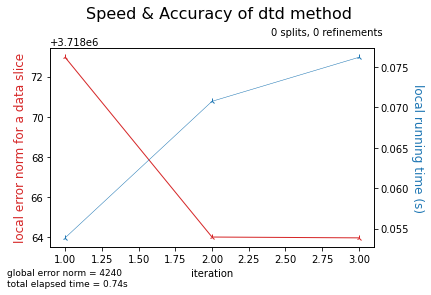

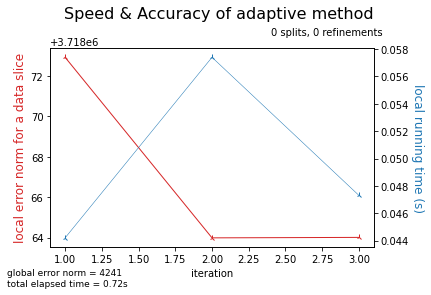

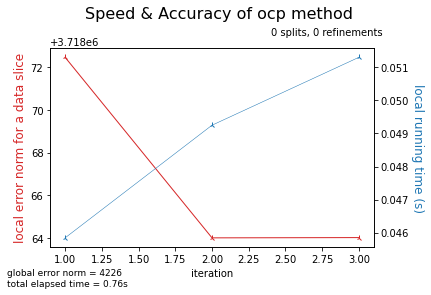

In [360]:
tensor_stream = create_tensor_stream(single_tensor, start_to_stream=200, batch_sizes=np.full((3), 100, dtype=int))
online_tensor_decomposition('single', single_tensor, tensor_stream, rank=3, n_iter=1, ul=3, ll=1, verbose=False)

### Synthetic Data

In [251]:
import csv
synthetic_data = tl.tensor(np.zeros([1000, 10, 20, 30], dtype='d'))

for i in range(200):
    start = time.time()
    with open('../Data/synthetic_data/data_normal/data{}.tensor'.format(i)) as file:
        reader = csv.reader(file, delimiter='\t')    
        for row in reader:
            indices = [[index] for index in np.int64(np.asarray(row[:-1]))-1]
            synthetic_data[tuple(indices)] = np.double(row[-1])
    print('>> synthetic_data{} loaded '.format(i), time.time() - start)

>> synthetic_data0 loaded  0.5746912956237793
>> synthetic_data1 loaded  0.5482354164123535
>> synthetic_data2 loaded  0.5501902103424072
>> synthetic_data3 loaded  0.5630953311920166
>> synthetic_data4 loaded  0.5598766803741455
>> synthetic_data5 loaded  0.5540995597839355
>> synthetic_data6 loaded  0.5599322319030762
>> synthetic_data7 loaded  0.5637965202331543
>> synthetic_data8 loaded  0.5802741050720215
>> synthetic_data9 loaded  0.5511288642883301
>> synthetic_data10 loaded  0.5595297813415527
>> synthetic_data11 loaded  0.5581164360046387
>> synthetic_data12 loaded  0.5519943237304688
>> synthetic_data13 loaded  0.5668282508850098
>> synthetic_data14 loaded  0.5532920360565186
>> synthetic_data15 loaded  0.549431324005127
>> synthetic_data16 loaded  0.5569989681243896
>> synthetic_data17 loaded  0.5541591644287109
>> synthetic_data18 loaded  0.5760290622711182
>> synthetic_data19 loaded  0.5535356998443604
>> synthetic_data20 loaded  0.5705890655517578
>> synthetic_data21 load

/home/lucetre/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


-----------------------------------
making init decomposition result: 4.3421149253845215

 >> dtd rank-20 n_iter-1
1th_iter: 0.016263961791992188 6190.71085354076 0
2th_iter: 0.016034603118896484 6188.330194180501 -0.7099285904917672
3th_iter: 0.015873432159423828 6187.381975245036 -0.5804508351257895
4th_iter: 0.021337509155273438 6186.931475344296 -0.5031386359630755
5th_iter: 0.0428159236907959 6185.581122437086 -0.45236958048085557
6th_iter: 0.015901565551757812 6185.446482280536 -0.41303937424740544
7th_iter: 0.015879392623901367 6184.624381435503 -0.38409277391948
8th_iter: 0.01604294776916504 6184.541207066124 -0.3593626615370595
9th_iter: 0.0159451961517334 6184.235058335094 -0.33948989293395737
10th_iter: 0.01901078224182129 6183.806386837001 -0.32312637470085176
11th_iter: 0.01598978042602539 7807.447565974681 4.188130840651565
12th_iter: 0.015986919403076172 7648.367683629246 2.2072577146514076
13th_iter: 0.015984773635864258 7647.9220270636315 1.7921889957075783
14th_iter: 

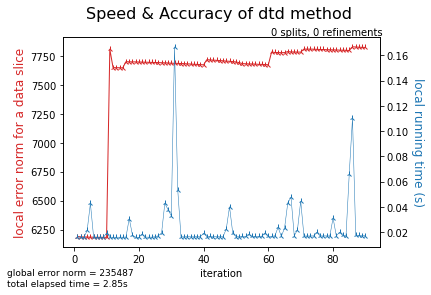

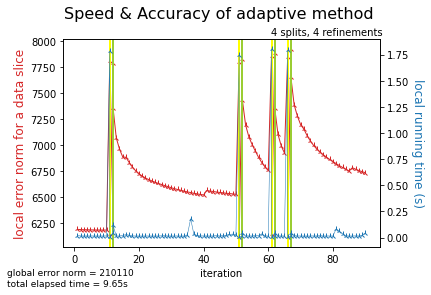

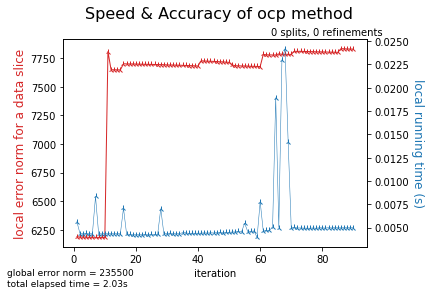

In [361]:
tensor_stream = create_tensor_stream(synthetic_data, start_to_stream=100, batch_sizes=np.full((90), 10, dtype=int))
online_tensor_decomposition('synthetic', synthetic_data, tensor_stream, rank=20, n_iter=1, ul=1.4, ll=1, verbose=False)

### Sample Video

In [357]:
import csv
sample_video = tl.tensor(np.zeros([205, 240, 320, 3], dtype='d'))

for i in range(41):
    start = time.time()
    with open('../Data/sample_video/data/video{}.tensor'.format(i)) as file:
        reader = csv.reader(file, delimiter='\t')    
        for row in reader:
            indices = [[index] for index in np.int64(np.asarray(row[:-1]))-1]
            sample_video[tuple(indices)] = np.double(row[-1])
    print('>> sample_video{} loaded '.format(i), time.time() - start)

>> sample_video0 loaded  21.165456771850586
>> sample_video1 loaded  21.023353338241577
>> sample_video2 loaded  21.017313957214355
>> sample_video3 loaded  21.204797983169556
>> sample_video4 loaded  21.14787220954895
>> sample_video5 loaded  21.023435831069946
>> sample_video6 loaded  21.23135781288147
>> sample_video7 loaded  20.874529600143433
>> sample_video8 loaded  21.151034355163574
>> sample_video9 loaded  21.071175575256348
>> sample_video10 loaded  21.342487573623657
>> sample_video11 loaded  21.062675952911377
>> sample_video12 loaded  21.334422826766968
>> sample_video13 loaded  21.110493898391724
>> sample_video14 loaded  21.257165670394897
>> sample_video15 loaded  21.02924370765686
>> sample_video16 loaded  21.262033939361572
>> sample_video17 loaded  21.044814109802246
>> sample_video18 loaded  21.25360870361328
>> sample_video19 loaded  21.04137372970581
>> sample_video20 loaded  21.102442979812622
>> sample_video21 loaded  20.941287517547607
>> sample_video22 loaded 

-----------------------------------
making init decomposition result: 7.6171040534973145

 >> dtd rank-10 n_iter-1
1th_iter: 0.14402103424072266 8667.004073307344 0
2th_iter: 0.11616659164428711 9132.99498129073 0.17828327196848046
3th_iter: 0.15967965126037598 9668.780101435837 1.5909885837605482
4th_iter: 0.14711523056030273 11578.562656679342 5.501451693429032
5th_iter: 0.17774057388305664 12003.983367148317 2.0678212874349993
6th_iter: 0.1053462028503418 11598.5796975596 1.106300643098099
7th_iter: 0.10464859008789062 11552.096272397426 0.9107427288800044
8th_iter: 0.16562843322753906 11371.213216020216 0.6793495901285311
9th_iter: 0.18680191040039062 11108.986878953521 0.4261455433466128
10th_iter: 0.10671377182006836 10801.448078244264 0.15482838080999095
11th_iter: 0.10458612442016602 10573.029808941677 -0.04564073524262805
12th_iter: 0.11686849594116211 10646.747355108555 0.021726030110467726
13th_iter: 0.11309504508972168 10421.639306290337 -0.1882808546257777
14th_iter: 0.185

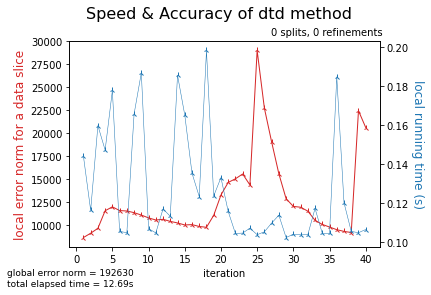

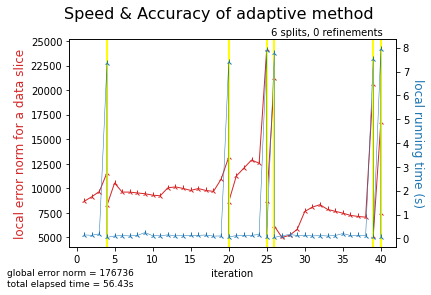

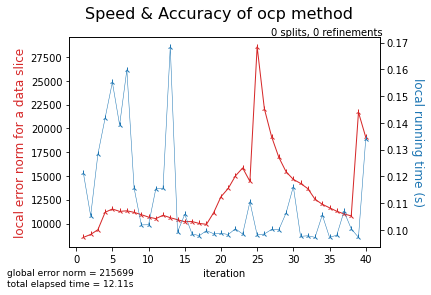

In [364]:
tensor_stream = create_tensor_stream(sample_video, start_to_stream=5, batch_sizes=np.full((40), 5, dtype=int))
online_tensor_decomposition('video', sample_video, tensor_stream, rank=10, n_iter=1, ul=5, ll=3, verbose=False)

### Server Room CFD

In [365]:
import csv
server_room_cfd = tl.tensor(np.zeros([3000, 3, 3, 34], dtype='d'))

start = time.time()
welford = Welford()
with open('../Data/ServerRoomCFD.tensor') as file:
    reader = csv.reader(file, delimiter='\t')    
    for row in reader:
        indices = np.asarray([index for index in np.int64(np.asarray(row[:-1]))-1])[[3, 0, 1, 2]]
        
        if indices[0] < 3000:
            server_room_cfd[tuple(indices)] = np.double(row[-1])
            welford(np.double(row[-1]))
server_room_cfd = (server_room_cfd - welford.mean) / welford.std
print('>> ServerRoomCFD loaded ', time.time() - start)

>> ServerRoomCFD loaded  19.459424018859863


-----------------------------------
making init decomposition result: 0.890427827835083

 >> dtd rank-10 n_iter-1
1th_iter: 0.007447481155395508 0.3141575723518418 0
2th_iter: 0.00751495361328125 0.46693279059402953 1.702007674590359
3th_iter: 0.0074939727783203125 0.41593812406289254 0.6629515533411849
4th_iter: 0.0075719356536865234 0.4261258236454343 0.6264240612338748
5th_iter: 0.007578372955322266 0.486734571291909 0.9570460667296723
6th_iter: 0.010094404220581055 0.8739812864079504 3.4779217396761517
7th_iter: 0.007671356201171875 1.6043374533045138 4.998342598481399
8th_iter: 0.00769805908203125 1.570521355999503 2.1194695751904162
9th_iter: 0.00779414176940918 1.463967693810204 1.4115521079238986
10th_iter: 0.007858037948608398 0.9005555361538354 0.22630172355033396
11th_iter: 0.007955551147460938 0.8049175429432406 0.039336023972632
12th_iter: 0.007822513580322266 0.7681341167844429 -0.03356338225277886
13th_iter: 0.00787353515625 0.8016417437760742 0.03555231861936429
14th_it

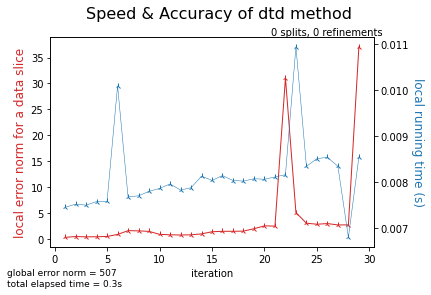

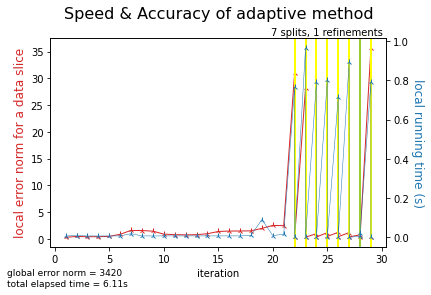

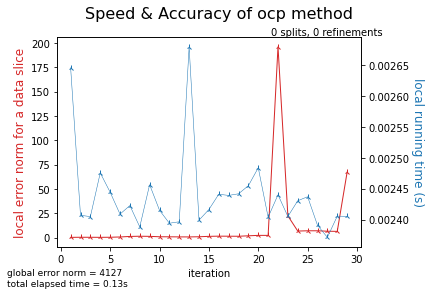

In [367]:
tensor_stream = create_tensor_stream(server_room_cfd, start_to_stream=100, batch_sizes=np.full((29), 100, dtype=int))
online_tensor_decomposition('room', server_room_cfd, tensor_stream, rank=10, n_iter=1, ul=10, ll=5, verbose=False)

### Stock

In [368]:
import pickle
with open('../Data/index_data.pkl', 'rb') as f:
    index_data = pickle.load(f)
    
index_data

,date,ks11
0,2017-01-03,2043.97
1,2017-01-04,2045.64
2,2017-01-05,2041.95
3,2017-01-06,2049.12
4,2017-01-09,2048.78
...,...,...
850,2020-06-24,2161.51
851,2020-06-25,2112.37
852,2020-06-26,2134.65
853,2020-06-29,2093.48


In [369]:
import csv

stock_data = tl.tensor(np.zeros([855, 189, 5], dtype='d'))
start = time.time()
with open('../Data/Stock_.tensor') as file:
    reader = csv.reader(file, delimiter='\t')    
    for row in reader:
        indices = np.asarray([index for index in np.int64(np.asarray(row[:-1]))])[[1, 0, 2]]
        stock_data[tuple(indices)] = np.double(row[-1])
print('>> stock_data loaded ', time.time() - start)

>> stock_data loaded  11.003591060638428


-----------------------------------
making init decomposition result: 0.10513782501220703

 >> dtd rank-3 n_iter-1
1th_iter: 0.0018701553344726562 0.4961409275601231 0
2th_iter: 0.0018281936645507812 0.4558994909734798 -28.520761347566207
3th_iter: 0.0018482208251953125 0.5228404582142934 1.7963156726328107
4th_iter: 0.001837015151977539 0.5457061607389528 1.9400618481598788
5th_iter: 0.0016965866088867188 0.5176427888664267 0.4349560624388476
6th_iter: 0.0017135143280029297 0.518994371857749 0.4413850018463883
7th_iter: 0.0016911029815673828 0.5419714275762204 1.2118348970130384
8th_iter: 0.0016868114471435547 0.5876793958818877 2.607488370880239
9th_iter: 0.001695394515991211 0.476318586197425 -1.1767901298717742
10th_iter: 0.0016930103302001953 0.49314745215195294 -0.5988254838889837
11th_iter: 0.0017139911651611328 0.9017278746489539 10.65102573445028
12th_iter: 0.0016949176788330078 0.4381122461105064 -0.9200972045560826
13th_iter: 0.0017070770263671875 0.4787692239857193 -0.50729

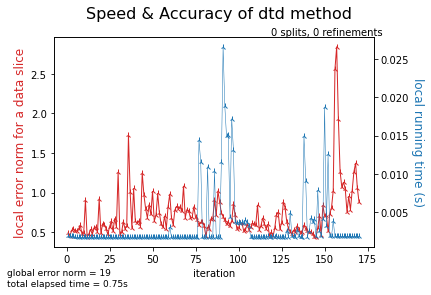

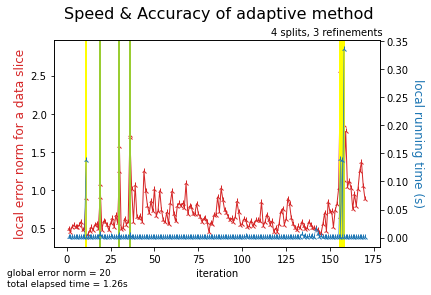

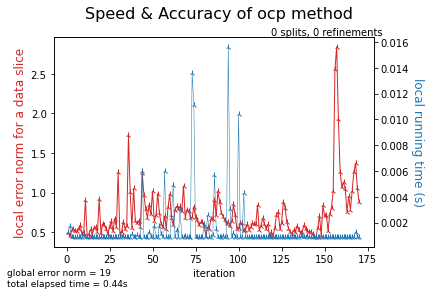

In [372]:
tensor_stream = create_tensor_stream(stock_data, start_to_stream=5, batch_sizes=np.full((170), 5, dtype=int))
online_tensor_decomposition('stock', stock_data, tensor_stream, rank=3, n_iter=1, ul=8, ll=4, verbose=False)